In [1]:
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(asctime)s - %(message)s')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import whisper

import tiktoken
whisper_tokenizer = whisper.tokenizer.get_tokenizer(tiktoken.get_encoding(tiktoken.list_encoding_names()[-1]), num_languages=1)

import json

with open('config.json') as fileobj:
    hf_token = json.load(fileobj)['hugging_face_token']

import torch

from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

import os

from IPython.display import clear_output
clear_output()

import utils
import data_extraction as da
import modelling as md

audio_dir = os.path.join('data', 'audio-vault')
transcription_dir = os.path.join(audio_dir, 'transcriptions')
diarization_dir = os.path.join(audio_dir, 'diarization_segments')

vsd_dir = os.path.join('data', 'VSD', 'VSD2014_officialrelease', 'VSD_2014_December_official_release', 'Hollywood-dev')
vsd_features_dir = os.path.join(vsd_dir, 'features')
vsd_annotations_dir = os.path.join(vsd_dir, 'annotations')

utils.ensure_dir_exists(transcription_dir)

transcript_df_fp = '{movie_name}-transcript.parquet'

max_break = 15 # seconds
max_seg_duration = 60 # seconds

batch_size = 16
num_epochs = 3

# enc_model = 'bert-large-uncased'
enc_model = 'answerdotai/ModernBERT-large'
whisper_model = 'turbo'

# FIXME: Don't use full model window: 8,192 tokens
# TODO: utilise bitsandbytes

### TODO:
- Creatures are rarely described in detail but assumed that person views clips of them beforehand?

In [2]:
def calc_speed_ratio(first_annot, last_annot, last_seg):
    return 1 + (last_seg - last_annot) / (last_annot - first_annot)

movie_offsets = {
    # Offset for first event, then multiplier for transcript speed differences
    'PiratesOfTheCarribeanTheCurseOfTheBlackPearl': (95, calc_speed_ratio(1772, 7065, 7291)), # Fantasy
    'SavingPrivateRyan': (14, calc_speed_ratio(663, 8907, 9263)), # War
    'FightClub': (-162, calc_speed_ratio(2542, 7676, 7782)), # Modern
    'IAmLegend': (2, 1), # Dystopian 
    'ReservoirDogs': (-13, calc_speed_ratio(565, 5490, 5465)) # Crime
}

In [3]:
# Extract and tokenize subtitles for matching
subs_dict = da.extract_subs()
subs_df_list = []

for movie, subs_df in subs_dict.items():
    subs_df['dialogue'] = da.clean_dialogue(subs_df['raw_dialogue'])
    subs_df['tokens'] = subs_df['dialogue'].apply(lambda x: whisper_tokenizer.encode(x))
    subs_df['movie'] = movie
    subs_df_list.append(subs_df)
    
subs_df = pd.concat(subs_df_list)

In [4]:
annotations_df = da.get_vsd_movie_annotations(vsd_annotations_dir, list(movie_offsets.keys()))
gore_mask = annotations_df.annotation_cat.eq('gore')
blood_mask = annotations_df.annotation_cat.eq('blood') & annotations_df.desc.isin(['low', 'medium', 'high'])
gory_df = annotations_df[gore_mask | blood_mask].copy()
gory_df['full_annotation_cat'] = gory_df['annotation_cat'] + '-' + gory_df['desc']
gory_df = gory_df.drop(columns=['desc'])

In [5]:
# Convert from 25 fps to seconds, and add ARBITRARY offset based on observation (movies out of sync)
gory_df[['start_sec', 'end_sec']] = gory_df[['start', 'finish']] / 25

gory_df = da.convert_time_to_readable_txt(gory_df, [('start_sec', 'start_txt'), ('end_sec', 'end_txt')])
# Buffering start and finish 1 second either side (no need to be precise)
gory_df['start_sec'] -= 1
gory_df['end_sec'] += 1
gory_df['seg_duration'] = gory_df['end_sec'] - gory_df['start_sec'] 

In [6]:
seg_df = da.get_segments(transcription_dir, gory_df['movie'].unique(), transcript_df_fp, whisper_tokenizer)
seg_df['duration'] = seg_df['end'] - seg_df['start']

gory_df = gory_df.sort_values('start')

# Add individual offsets to align each movie with audio recording
for movie, (offset, ratio) in movie_offsets.items():
    vec = seg_df.loc[seg_df.movie.eq(movie), ['start']]
    first_annot = gory_df['start_sec'][gory_df.movie.eq(movie)].iloc[0]
    seg_df.loc[seg_df.movie.eq(movie), ['start']] = first_annot + (vec - offset - first_annot) / ratio

seg_df['end'] = seg_df['start'] + seg_df['duration']

seg_df = da.convert_time_to_readable_txt(seg_df, [('start', 'start_txt'), ('end', 'end_txt')])

In [7]:
tokenizer = AutoTokenizer.from_pretrained(enc_model)
seg_df['num_tokens'] = [len(x) for x in tokenizer(list(seg_df['text']))['input_ids']]
seg_df = seg_df.sort_values(['movie', 'start'])

In [8]:
agg_rows_list = []
prev_row = dict(seg_df.iloc[0])

for row in seg_df.iloc[1:].to_dict(orient="records"):
    
    is_under_token_limit = (prev_row['num_tokens'] + row['num_tokens']) < tokenizer.model_max_length - 5
    is_under_duration_limit = (row['end'] - prev_row['start']) < max_seg_duration
    is_under_max_break = (row['start'] - prev_row['end']) < max_break
    is_same_speaker = prev_row['movie'] == row['movie'] and prev_row['speaker'] == row['speaker'] 
    
    if all((is_same_speaker, is_under_max_break, is_under_duration_limit, is_under_token_limit)):
        prev_row['end_txt'] = row['end_txt']
        prev_row['duration'] += row['duration']
        prev_row['text'] += (' ' + row['text'])
        prev_row['end'] = row['end']
        prev_row['num_tokens'] += row['num_tokens']
        
    else:
        agg_rows_list.append(prev_row)
        prev_row = row.copy()
    
agg_seg_df = pd.DataFrame.from_records(agg_rows_list).sort_values(['movie', 'start']).reset_index(drop=True)

In [9]:
# Mark each segment as containing gore by looping through all the gory annotations
agg_seg_df['has_gore'] = False
agg_seg_df['has_blood'] = False
agg_seg_df['blood_cat'] = pd.NA

agg_seg_df['gore_start'] = -1 
agg_seg_df['gore_end'] = -1 

agg_seg_df['blood_start'] = -1 
agg_seg_df['blood_end'] = -1 

seg_df_list = []

for movie in gory_df.movie.unique():
    
    curr_gory_df = gory_df[gory_df.movie.eq(movie)].copy()
    curr_seg_df = agg_seg_df[agg_seg_df.movie.eq(movie)].copy()
    
    for ii in range(curr_gory_df.shape[0]):
        
        cat = 'gore' if 'gore' in curr_gory_df['annotation_cat'].iloc[ii] else 'blood'
        
        # Identify any segments that overlap with gory segment
        anot_start_after_seg = curr_seg_df.start > curr_gory_df['end_sec'].iloc[ii]
        seg_end_before_anot = curr_seg_df.end < curr_gory_df['start_sec'].iloc[ii]
        curr_anot_mask = np.logical_not(anot_start_after_seg | seg_end_before_anot)
        
        if sum(curr_anot_mask) > 0:
            curr_seg_df[f'{cat}_start'] = np.where(curr_anot_mask, curr_gory_df['start_sec'].iloc[ii], curr_seg_df[f'{cat}_start'])
            curr_seg_df[f'{cat}_end'] = np.where(curr_anot_mask, curr_gory_df['end_sec'].iloc[ii], curr_seg_df[f'{cat}_end'])
            
            curr_seg_df[f'has_{cat}'] = curr_seg_df[f'has_{cat}'] | curr_anot_mask
            
            if cat == 'blood':
                curr_seg_df['blood_cat'] = np.where(curr_anot_mask, curr_gory_df['full_annotation_cat'].iloc[ii], curr_seg_df['blood_cat'])
                
        # No overlap, so find closest segment   
        else:
            annot_midpoint = (curr_gory_df['start_sec'].iloc[ii] + curr_gory_df['end_sec'].iloc[ii]) / 2
            closest_start_idx = next(iter(curr_seg_df.start[curr_seg_df.start > annot_midpoint].index), None)
            closest_start = abs(curr_seg_df.start[closest_start_idx] - annot_midpoint) if closest_start_idx else curr_seg_df.end.iloc[-1]
            closest_end_idx = max(0, closest_start_idx - 1) if closest_start_idx else curr_seg_df.index[-1]
            closest_end = abs(curr_seg_df.end[closest_end_idx] - annot_midpoint) if closest_end_idx else curr_seg_df.end.iloc[-1]
            
            closest_seg_idx = closest_end_idx
            
            if closest_start is not None and closest_end is not None and closest_start < closest_end:
                closest_seg_idx = closest_start_idx
                
            curr_seg_df[f'{cat}_start'][closest_seg_idx] = curr_gory_df['start_sec'].iloc[ii]
            curr_seg_df[f'{cat}_end'][closest_seg_idx] = curr_gory_df['end_sec'].iloc[ii]
            
            curr_seg_df[f'has_{cat}'][closest_seg_idx] = True
            
            if cat == 'blood':
                curr_seg_df['blood_cat'][closest_seg_idx] = curr_gory_df['full_annotation_cat'].iloc[ii]
                
    seg_df_list.append(curr_seg_df)
    
cat_seg_df = pd.concat(seg_df_list).reset_index(drop=True)

# Hide warnings that think I don't understand how copying works
clear_output()

In [10]:
cat_seg_df['cat'] = np.select(
    [cat_seg_df['has_gore'] | cat_seg_df['blood_cat'].isin(['blood-high', 'blood-medium']), cat_seg_df.has_blood],
    ['gore', 'blood'],
    default='neutral'
)

In [11]:
cat_seg_df['tokens'] = tokenizer(list(cat_seg_df['text']), add_special_tokens=False)['input_ids']
tokens_w_context = []

token_limit = tokenizer.model_max_length - 1

for ii in range(cat_seg_df.shape[0]):
    context_len = (token_limit - cat_seg_df['num_tokens'][ii]) // 2
    prev_seg = tokenizer.decode(cat_seg_df['tokens'][ii - 1][-context_len:]) if ii > 0 else ''
    next_seg = tokenizer.decode(cat_seg_df['tokens'][ii + 1][:context_len]) if ii < cat_seg_df.shape[0] - 1 else ''
    tokens_w_context.append('[CLS]' + prev_seg + '[SEP]' + tokenizer.decode(cat_seg_df['tokens'][ii]) + '[SEP]' + next_seg)

In [12]:
# TODO: Inject a flag into the model indicating how much context was included

In [13]:
from typing import List 

In [14]:
def create_test_train_split(tokenized_input, movie_list: List[str], tokenizer):
    set_mask = cat_seg_df['movie'].isin(movie_list)
    set_enc = tokenizer([txt for in_set, txt in zip(set_mask, tokenized_input) if in_set], add_special_tokens=False, padding=True)
    set_y = cat_seg_df['has_gore'][set_mask]

    ds = md.AudioSegDataset(set_enc, set_y)
    
    return ds, set_y 

In [15]:
# total_training_steps = (len(train_y) // batch_size) * num_epochs
# quarter_epoch_steps = (total_training_steps // num_epochs) // 4

training_args = TrainingArguments(
    num_train_epochs=num_epochs,
    fp16=True,
    weight_decay=0.01,
    
    eval_strategy='epoch',
    # eval_steps=quarter_epoch_steps,
    logging_strategy="epoch",         
    # logging_steps=quarter_epoch_steps,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    
    output_dir="./results",
    logging_dir="./logs",
    report_to="none"
)


In [16]:
# from peft import get_peft_model, LoraConfig, TaskType
# from transformers import AutoModelForSequenceClassification

# base_model = AutoModelForSequenceClassification.from_pretrained(enc_model, num_labels=1)

# lora_config = LoraConfig(
#     r=8,
#     lora_alpha=16,
#     target_modules=["query", "value"],  # key attention layers
#     lora_dropout=0.1,
#     bias="none",
#     task_type=TaskType.SEQ_CLS
# )

# model = get_peft_model(base_model, lora_config)



In [ ]:
movies = cat_seg_df.movie.unique()
for movie in movies:
    logging.info(f'Current Test Set: {movie}')    
    train_ds, train_y = create_test_train_split(tokens_w_context, [x for x in movies if x != movie], tokenizer)
    test_ds, test_y = create_test_train_split(tokens_w_context, [movie], tokenizer)

    n_pos = train_y.sum()
    pos_weight = torch.tensor([(train_y.shape[0] - n_pos) / n_pos], dtype=torch.float)
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
    model = md.CustomLossModel(enc_model, loss_fn, [ii for ii in range(26, 29)])
    logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)
    
    for name, param in model.named_parameters():
        if not param.requires_grad:
            print(f"[FROZEN] {name}")
        else:
            print(f"[TRAINABLE] {name}")

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        compute_metrics=md.compute_metrics,
        callbacks=[md.FractionalTrainEvalCallback]
    )

    torch.cuda.empty_cache()
    trainer.train()

INFO - 2025-05-21 22:43:30,770 - Current Test Set: SavingPrivateRyan


Epoch,Training Loss,Validation Loss


In [ ]:
train_preds = trainer.predict(train_ds)

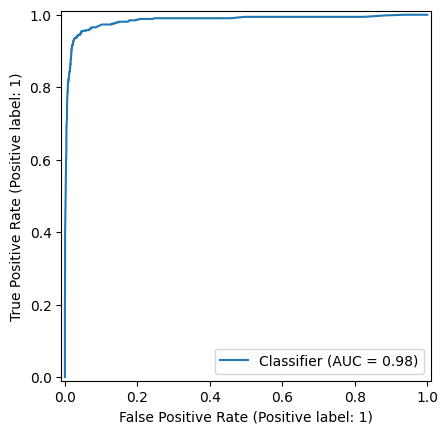

In [ ]:
RocCurveDisplay.from_predictions(train_y, train_preds.predictions)